In [1]:
import pandas as pd
import numpy as np
import re #取出稱謂的字首用的
from IPython.display import display, HTML

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)

data_train = pd.read_csv("https://kaggle-getting-started.s3-ap-northeast-1.amazonaws.com/titanic/train.csv")
data_val = pd.read_csv("https://kaggle-getting-started.s3-ap-northeast-1.amazonaws.com/titanic/test.csv")
data_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
#看看存活與沒存活比例
data_train['Survived'].mean()

np.float64(0.3838383838383838)

In [4]:
data_val

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [5]:
data_train.shape, data_train.Survived.sum(), data_val.shape

((891, 12), np.int64(342), (418, 11))

In [6]:
data_train.isnull().sum(),data_val.isnull().sum()# Age與Cabin有遺失值

(PassengerId      0
 Survived         0
 Pclass           0
 Name             0
 Sex              0
 Age            177
 SibSp            0
 Parch            0
 Ticket           0
 Fare             0
 Cabin          687
 Embarked         2
 dtype: int64,
 PassengerId      0
 Pclass           0
 Name             0
 Sex              0
 Age             86
 SibSp            0
 Parch            0
 Ticket           0
 Fare             1
 Cabin          327
 Embarked         0
 dtype: int64)

In [7]:
data_train.dtypes #Age是連續型特徵，Cabin是類別型

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

714


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13856\2807716389.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_train['Age'].dropna())


<Axes: xlabel='Age', ylabel='Density'>

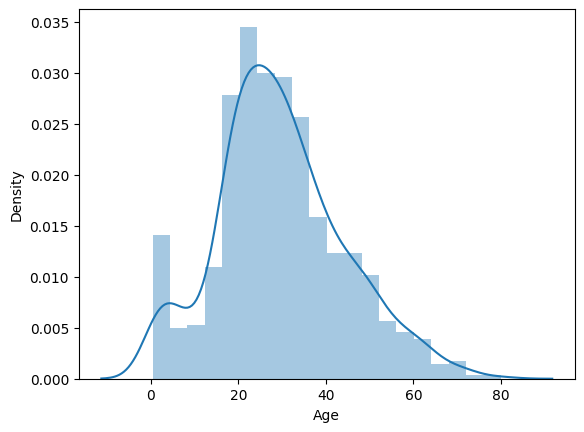

In [8]:
not_nan_count = len(data_train[~data_train['Age'].isna()]) #算出Age裡面不是Nan的數量
print(not_nan_count)

sns.distplot(data_train['Age'].dropna()) 
#這個分配圖是看看符不符合常態分配，稍後可以取log，或許更像常態分配，有助於羅吉斯回歸的分類能力，.dropna()其實可以不用

In [9]:
# 合併training data和validation data，這是為了方便等等一起修補資料
data_df = pd.concat([data_train, data_val], ignore_index=True)
data_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [10]:
#取出Title的訊息
regex = re.compile('([A-Za-z]+)\.') #[A-Za-z]+ 是要批配多個英文字母，()是捕捉為一個群組，\.是稱謂後面的點，比如: Mr.
data_df['Title'] = data_df.Name.map(lambda x: regex.search(x)[0])#用在Name欄位上，儲存稱謂到新欄位Title

data_df['Title']

0           Mr.
1          Mrs.
2         Miss.
3          Mrs.
4           Mr.
         ...   
1304        Mr.
1305      Dona.
1306        Mr.
1307        Mr.
1308    Master.
Name: Title, Length: 1309, dtype: object

In [11]:
#拿掉最後一個的字母(就是那個.)
data_df['Title'] = data_df.Title.map(lambda x: x[:-1]) #拿掉.，只剩稱謂
data_df['Title'].unique(), data_df['Title'].count()

(array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
        'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
        'Jonkheer', 'Dona'], dtype=object),
 np.int64(1309))

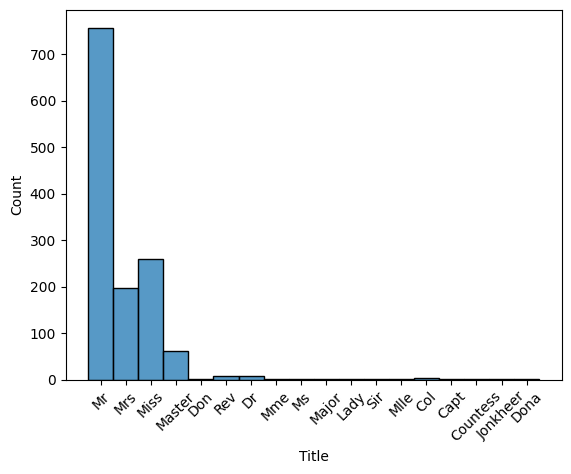

Title
Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Major         2
Mlle          2
Ms            2
Mme           1
Don           1
Sir           1
Lady          1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: count, dtype: int64

In [12]:
#看看每種稱謂人數多寡
sns.histplot(data_df['Title'])
plt.xticks(rotation = 45)
plt.show()

data_df['Title'].value_counts()

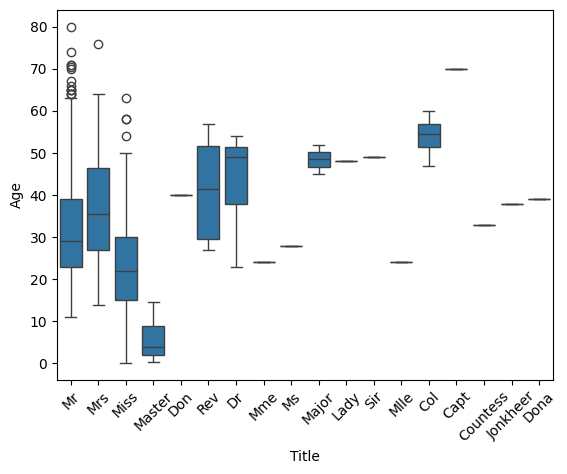

count     7.000000
mean     43.571429
std      11.731115
min      23.000000
25%      38.000000
50%      49.000000
75%      51.500000
max      54.000000
Name: Age, dtype: float64

In [13]:
#Mr和Dr差的比較多，用distplot或boxplot檢查有沒有極端值
sns.boxplot(x='Title', y='Age', data = data_df)
plt.xticks(rotation = 45)
plt.show()

#看看最大值和最小值
data_df[data_df['Title'] == 'Dr']['Age'].describe()

In [14]:
#接下來我們要處理Age的遺失值，我打算用每種稱謂的平均值，去填補相同稱謂的人的Age的遺失值
#我們先看看每個稱謂的平均數和中位數的差異？
Age_mean = data_df[['Title', 'Age']].groupby(by='Title').mean().round(2)
Age_median = data_df[['Title', 'Age']].groupby(by='Title').median().round(2)

#整理表格
Age_mean.columns = ['Age Mean']
Age_median.columns = ['Age Median']
Age_mean.reset_index(inplace=True)
Age_median.reset_index(inplace=True)

#呈現資料
# display(Age_mean)
# display(Age_median)
combined = pd.concat([Age_mean.set_index('Title'), Age_median.set_index('Title')], axis = 1)
combined.columns = ['Age Mean', 'Age Median']

display(HTML(combined.to_html()))

,Age Mean,Age Median
Title,,
Capt,70.00,70.0
Col,54.00,54.5
Countess,33.00,33.0
Don,40.00,40.0
Dona,39.00,39.0
Dr,43.57,49.0
Jonkheer,38.00,38.0
Lady,48.00,48.0
Major,48.50,48.5


['Mr' 'Mrs' 'Miss' 'Master' 'Rare']
Title
Mr        767
Miss      266
Mrs       198
Master     61
Rare       17
Name: count, dtype: int64


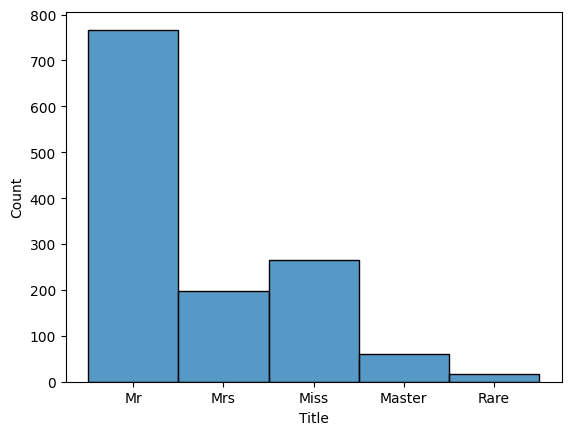

In [15]:
#把上面那些稱謂，同性別的放一起，比如:Ms和Mlle這種年輕女性的稱呼就放到Miss，這麼做是為了避免類別多而產生噪音(就是不必要的訊息)
data_df['Title'] = data_df.Title.replace(['Ms', 'Mlle', 'Lady', 'Dona'], 'Miss') #年輕女性稱呼
data_df['Title'] = data_df.Title.replace(['Mme'], 'Mrs') #成熟女性稱呼

#把跟成熟男生有關的稱謂放到Mr，小男生是Master，就不放進去
data_df['Title'] = data_df.Title.replace(['Don', 'Rev', 'Jonkheer'], 'Mr')

#剩下Dr、Major(將軍)...這些看不太出來性別與年紀、但是似乎都滿有地位的稱謂，就放在Rare
data_df['Title'] = data_df.Title.replace(['Dr', 'Major', 'Sir', 'Col', 'Capt', 'Countess'], 'Rare')

#看看整理完稱謂後，有什麼稱謂？
print(data_df['Title'].unique())

#畫出histgram看看每種稱謂的數量
sns.histplot(data_df['Title'])

print(data_df['Title'].value_counts())

In [16]:
#我們再看看，整理稱謂後，每個稱謂的平均數和中位數的差異？
Age_mean = data_df[['Title', 'Age']].groupby(by='Title').mean().round(2)
Age_median = data_df[['Title', 'Age']].groupby(by='Title').median().round(2)

#整理表格
Age_mean.columns = ['Age Mean']
Age_median.columns = ['Age Median']
Age_mean.reset_index(inplace=True)
Age_median.reset_index(inplace=True)

#呈現資料
# display(Age_mean)
# display(Age_median)
combined = pd.concat([Age_mean.set_index('Title'), Age_median.set_index('Title')], axis = 1)
combined.columns = ['Age Mean', 'Age Median']

display(HTML(combined.to_html()))

,Age Mean,Age Median
Title,,
Master,5.48,4.0
Miss,22.03,22.0
Mr,32.40,29.0
Mrs,36.92,35.0
Rare,48.12,49.5


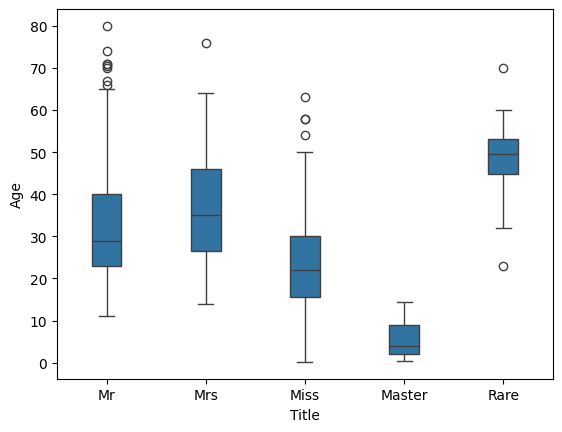

count    591.000000
mean      32.396785
std       12.435508
min       11.000000
25%       23.000000
50%       29.000000
75%       40.000000
max       80.000000
Name: Age, dtype: float64

In [17]:
#Mr的比較多，用distplot或boxplot檢查有沒有極端值
sns.boxplot(x='Title', y='Age', data = data_df, width=0.3)
# plt.xticks(rotation = 45)
plt.show()

#看看最大值和最小值
data_df[data_df['Title'] == 'Mr']['Age'].describe()

In [18]:
#用每個Title的年齡中位數填補Nan
data_df.loc[(data_df.Age.isnull()) & (data_df.Title=='Master'), 'Age'] = Age_median.loc[Age_median.Title=='Master', 'Age Median'][0]
data_df.loc[(data_df.Age.isnull()) & (data_df.Title=='Miss'), 'Age'] = Age_median.loc[Age_median.Title=='Miss', 'Age Median'][1]
data_df.loc[(data_df.Age.isnull()) & (data_df.Title=='Mr'),'Age'] = Age_median.loc[Age_median.Title=='Mr', 'Age Median'][2]
data_df.loc[(data_df.Age.isnull()) & (data_df.Title=='Mrs'), 'Age']= Age_median.loc[Age_median.Title=='Mrs', 'Age Median'][3]
data_df.loc[(data_df.Age.isnull()) & (data_df.Title=='Rare'), 'Age']= Age_median.loc[Age_median.Title=='Rare', 'Age Median'][4]

In [19]:
data_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title'],
      dtype='object')

In [20]:
#看看性別(Sex)和艙等(Pclass)與存活率的關係
print(data_df['Pclass'].unique())# Pclass是艙等，1最好，3最差

Survival_Rate = data_df[['Sex', 'Pclass', 'Survived']].groupby(by=['Sex','Pclass']).agg(np.mean)*100 
#groupby()對'Sex','Pclass'分組，agg()對每組計算是否存活(Survived)的平均，比如:0 1 0 1 1 平均是3/5 = 0.6，*100變成60%
Survival_Rate.columns = ['Survival_Rate(%)']
Survival_Rate.reset_index()

[3 1 2]


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13856\633491165.py:4: FutureWarning: The provided callable <function mean at 0x00000296E7A6CDC0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  Survival_Rate = data_df[['Sex', 'Pclass', 'Survived']].groupby(by=['Sex','Pclass']).agg(np.mean)*100


,Sex,Pclass,Survival_Rate(%)
0,female,1,96.808511
1,female,2,92.105263
2,female,3,50.000000
3,male,1,36.885246
4,male,2,15.740741
5,male,3,13.544669


In [21]:
# data_df.dtypes

In [22]:
#因此我們依照'Survival_Rate(%)'有6種級別，因此我們可以依照性別與座艙給予不同存活率位階1~6
data_df['Sex_Pclass'] = np.nan #建立新欄位
data_df['Sex_Pclass'] = data_df['Sex_Pclass'].astype('Int64') #nan轉為整數，等一下轉為1 2 3
data_df.loc[(data_df.Sex=='female') & (data_df.Pclass==1), 'Sex_Pclass'] = 1
data_df.loc[(data_df.Sex=='female') & (data_df.Pclass==2), 'Sex_Pclass'] = 2
data_df.loc[(data_df.Sex=='female') & (data_df.Pclass==3), 'Sex_Pclass'] = 3
data_df.loc[(data_df.Sex=='male') & (data_df.Pclass==1), 'Sex_Pclass'] = 4
data_df.loc[(data_df.Sex=='male') & (data_df.Pclass==2), 'Sex_Pclass'] = 5
data_df.loc[(data_df.Sex=='male') & (data_df.Pclass==3), 'Sex_Pclass'] = 6

In [23]:
#對Fare(票價)以及Age取log
data_df['log_Fare'] = np.log1p(data_df['Fare']) #這裡用log(x+1)，避免x是0
data_df['log_Age'] = np.log1p(data_df['Age'])

#做label embedding，將femle -> 0，male -> 1
sex_mapping = {'female': 0, 'male': 1}
data_df['Sex'] = data_df.Sex.map(sex_mapping)

In [24]:
#因為Ticket欄位前面的英文字母跟住的區域有關，所以我們把它分出來，沒英文字母的就顯示'X'
data_df['Ticket_info'] = data_df.Ticket.apply(lambda x: x.replace('.','').replace('/','').strip().split()[0] if not x.isdigit() else 'X')
data_df['Ticket_info'].unique()                           

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

In [25]:
#看看現在欄位有什麼型態?
data_df.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Title           object
Sex_Pclass       Int64
log_Fare       float64
log_Age        float64
Ticket_info     object
dtype: object

In [26]:
# print(data_df['Cabin'].unique())

# #Cabin(船艙)我們就留下首字的英文字母，'NAN'轉成U
# data_df['Cabin_Simplified'] = data_df['Cabin'].str[0]
# data_df['Cabin_Simplified'] = data_df['Cabin_Simplified'].fillna('U')

# print(data_df['Cabin_Simplified'].unique())

# sns.histplot(data_df['Cabin_Simplifi'])

In [27]:
#我們把Ticket、Cabin(船艙)、Ticket_info(住的區域)等類別欄位轉成數字
for col in ['Title', 'Cabin', 'Ticket_info']:
    data_df[col]=data_df[col].astype('category').cat.codes #astype('category')變成類別，cat.codes變成數字，比如:['A','B','C'] -> ['0','1','2']

#對Ticket_info做Normalize
data_df['Ticket_info'] = data_df['Ticket_info']/(data_df['Ticket_info'].max() - data_df['Ticket_info'].min())
data_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Sex_Pclass,log_Fare,log_Age,Ticket_info
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,-1,S,2,6,2.110213,3.135494,0.055556
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,106,C,3,1,4.280593,3.663562,0.388889
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,-1,S,1,3,2.188856,3.295837,0.861111
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,70,S,3,1,3.990834,3.583519,1.000000
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,-1,S,2,6,2.202765,3.583519,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",1,29.0,0,0,A.5. 3236,8.0500,-1,S,2,6,2.202765,3.401197,0.055556
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,64,C,1,1,4.699571,3.688879,0.388889
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,-1,S,2,6,2.110213,3.676301,0.777778
1307,1308,NaN,3,"Ware, Mr. Frederick",1,29.0,0,0,359309,8.0500,-1,S,2,6,2.202765,3.401197,1.000000


In [28]:
#分回原本的train與validation
data_train = data_df[pd.notnull(data_df.Survived)]
data_val = data_df[pd.isnull(data_df.Survived)]

#刪除train的PassengerId以及val的Survived
data_train.drop(['PassengerId'], axis=1, inplace=True)
data_val.drop(['Survived'], axis=1, inplace=True)

#將data_train的X與y分開
data_train_Y = data_train.Survived
data_train_X = data_train.drop(['Survived'], axis=1)

#這裡我們選擇用Sex(性別)、Sex_Pclass(性別與艙等)、Title(稱謂)、log_Fare(票價取log)、log_Age(年紀取log)、Ticket_info(住的區域)等特徵做modeling
data_train_X = data_train_X[['Sex', 'Sex_Pclass', 'Title', 'log_Fare', 'log_Age', 'Ticket_info']]
data_val = data_val[['PassengerId', 'Sex', 'Sex_Pclass', 'Title', 'log_Fare', 'log_Age', 'Ticket_info']]

#拆分出X_train和y_train...
X_train, X_test, y_train, y_test = train_test_split(data_train_X, data_train_Y, test_size=0.2, random_state=123)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13856\2929177561.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.drop(['PassengerId'], axis=1, inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13856\2929177561.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val.drop(['Survived'], axis=1, inplace=True)


((712, 6), (179, 6), (712,), (179,))

In [29]:
#用LogisticRegression先對train做modeling
logit_model = LogisticRegression(solver='lbfgs', penalty=None, random_state=123, max_iter=500) #lbfgs是一種最佳化方法，跟梯度下降類似，但更為快速
logit_model.fit(X_train, y_train)

print('Coef of LogisticRegression: ', logit_model.coef_)
print('intercept of LogisticRegression: ', logit_model.intercept_)

Coef of LogisticRegression:  [[ 0.86750806 -1.16320309  0.07765129 -0.03238375 -0.89509242  0.04818003]]
intercept of LogisticRegression:  [6.63338883]


In [30]:
#看看準確度(accuracy)
logit_model.score(X_train, y_train), logit_model.score(X_test, y_test)

(0.800561797752809, 0.8212290502793296)

In [31]:
#做10-Fold，看看是否起伏很大
score = cross_val_score(logit_model, X_train, y_train, scoring='accuracy', cv=10)
print('10-Fold Cross Validation Scores: \n', score)
print('10-Fold Cross Validation Scores Mean: \n', score.mean())

10-Fold Cross Validation Scores: 
 [0.76388889 0.81944444 0.8028169  0.74647887 0.73239437 0.78873239
 0.78873239 0.78873239 0.85915493 0.81690141]
10-Fold Cross Validation Scores Mean: 
 0.7907276995305165


In [32]:
#看看其他指標
y_pred = logit_model.predict(X_test)

print('classification report: \n',classification_report(y_test, y_pred))
print('confusion matrix: \n', confusion_matrix(y_test, y_pred))

classification report: 
               precision    recall  f1-score   support

         0.0       0.87      0.85      0.86       114
         1.0       0.75      0.77      0.76        65

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

confusion matrix: 
 [[97 17]
 [15 50]]


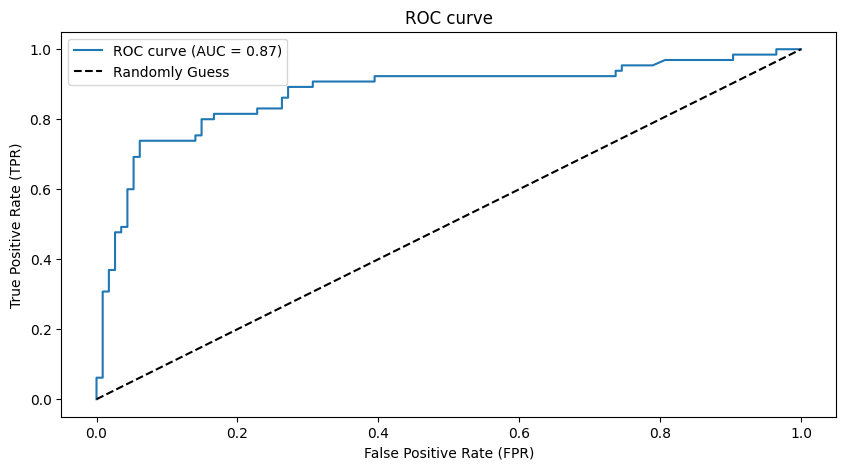

In [33]:
#我們可以畫ROC curve，看看在何種分類門檻值(0~1)，哪裡的分類能力最好
y_score = logit_model.predict_proba(X_test)[:,1]

#計算與繪製ROC curve
fpr, tpr, threshold = roc_curve(y_test, y_score)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_score):.2f})')
plt.plot([0,1], [0,1], 'k--', label='Randomly Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()

In [34]:
#用ROC曲線找出最好的點，是在這區線上，最接近(0,1)的地方，所以我們可以算(0,1)到(TPR,FPR)的最小距離，那個時候的threshold就是best_threshold...
distance = np.sqrt((1-tpr)**2 + (fpr)**2)
best_threshold = threshold[np.argmin(distance)]#計算所有(0,1)到(TPR,FPR)的距離，再用argmin()標示那個最小距離為1，其他都是0，選出這threshold作為best_threshold

print('Best Threshold: ',best_threshold.round(3))

Best Threshold:  0.473


In [35]:
#有了best_threshold，我們可以將y_pred分類以0.5為門檻，換成以best_threshold為門檻
y_score = logit_model.predict_proba(X_test)[:,1]

y_pred_with_best_threshold = (y_score > best_threshold).astype(int) #超過best_threshold的y_scores是True，小於等於best_threshold的是False，再用astype()booling變int

#重劃分類表與混淆矩陣
print('classification report with Best Threshold: \n',classification_report(y_test, y_pred_with_best_threshold))
print('confusion matrix with Best Threshold: \n', confusion_matrix(y_test, y_pred_with_best_threshold))

classification report with Best Threshold: 
               precision    recall  f1-score   support

         0.0       0.88      0.83      0.86       114
         1.0       0.73      0.80      0.76        65

    accuracy                           0.82       179
   macro avg       0.81      0.82      0.81       179
weighted avg       0.83      0.82      0.82       179

confusion matrix with Best Threshold: 
 [[95 19]
 [13 52]]


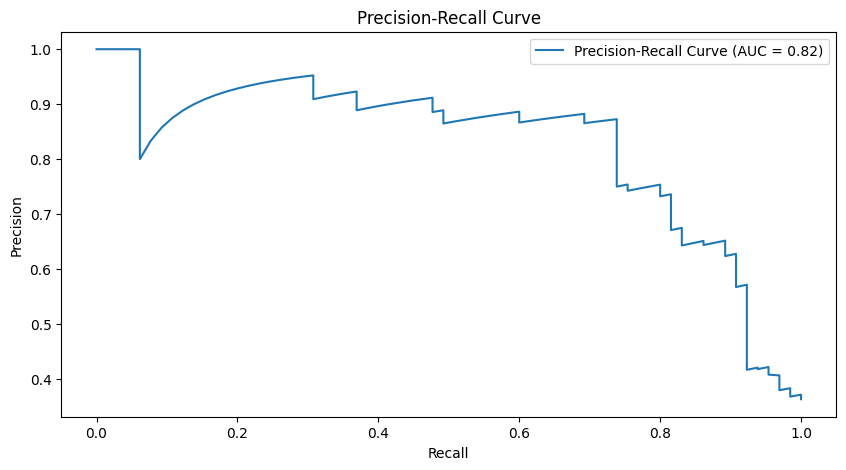

In [36]:
#要畫precision-recall curve，我們要先有真正的預測標籤: y_true與預測的機率: y_pred_prob...
y_true = y_test
y_pred_proba = logit_model.predict_proba(X_test)

precision, recall, threshold = precision_recall_curve(y_true, y_pred_proba[:,1])
auc_score = auc(recall, precision)

#用precision-recall curve
plt.figure(figsize=(10,5))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [37]:
# precision, recall, threshold
#我們要取的threshold是precision和recall同時是最大，那時的threshold

best_threshold = threshold[np.argmax((2*precision*recall)/(precision+recall))] 
                              #argmax是把所有precision+recall最大的值當成1，其他當成0，然後挑出是1的那一組 f1-score最大的threshold當作best_threshold
print('Best Threshold: ',best_threshold)

Best Threshold:  0.5969593767779817


In [38]:
#有了best_threshold，我們可以將y_pred分類以0.5為門檻，換成以best_threshold為門檻
y_scores = logit_model.predict_proba(X_test)[:,1]

y_pred_with_best_threshold = (y_scores > best_threshold).astype(int) #超過best_threshold的y_scores是True，小於等於best_threshold的是False，再用astype()booling變int

#重劃分類表與混淆矩陣
print('classification report with Best Threshold: \n',classification_report(y_test, y_pred_with_best_threshold))
print('confusion matrix with Best Threshold: \n', confusion_matrix(y_test, y_pred_with_best_threshold))

classification report with Best Threshold: 
               precision    recall  f1-score   support

         0.0       0.86      0.94      0.90       114
         1.0       0.87      0.72      0.79        65

    accuracy                           0.86       179
   macro avg       0.86      0.83      0.84       179
weighted avg       0.86      0.86      0.86       179

confusion matrix with Best Threshold: 
 [[107   7]
 [ 18  47]]


In [39]:
#rf_model = RandomForestClassifier(n_estimators=500,
#                                    random_state=123,
#                                    n_jobs=-1)
# rf_model.fit(X_train, y_train)

param_grid = {'n_estimators': [100, 300, 500],
              'min_samples_leaf': [1, 2, 5],
              'min_samples_split': [2, 4, 6],
              'max_depth': [5, 10, 15]
              } #'max_features': ['sqrt', 'log2']

cv = KFold(n_splits=3, shuffle=True, random_state=123)

rf_cv = GridSearchCV(RandomForestClassifier(random_state=123),
                     param_grid=param_grid,
                     cv=cv,
                     scoring='f1',
                     n_jobs=-1)

rf_cv.fit(X_train, y_train)
best_params = rf_cv.best_params_
print('best parameters: ', best_params)

C:\Python310\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


best parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [40]:
# rf_model.score(X_train, y_train), rf_model.score(X_test, y_test)
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train, y_train)

rf_model.score(X_train, y_train), rf_model.score(X_test, y_test)

(0.9480337078651685, 0.8435754189944135)

In [41]:
y_pred = rf_model.predict(X_test)

print('classification report: \n',classification_report(y_test, y_pred))
print('confusion matrix: \n', confusion_matrix(y_test, y_pred))

classification report: 
               precision    recall  f1-score   support

         0.0       0.87      0.89      0.88       114
         1.0       0.79      0.77      0.78        65

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

confusion matrix: 
 [[101  13]
 [ 15  50]]


In [43]:
#特徵重要性排序
rf_feature_importance = rf_model.feature_importances_
rf_feature_importance_df = pd.DataFrame({'feature': X_train.columns,
                                         'feature importance': rf_feature_importance})
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='feature importance',ascending=False)
rf_feature_importance_df

,feature,feature importance
1,Sex_Pclass,0.307422
3,log_Fare,0.227708
4,log_Age,0.194113
0,Sex,0.120863
2,Title,0.099607
5,Ticket_info,0.050287


C:\Users\ASUS\AppData\Local\Temp\ipykernel_19380\533655153.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='feature', y='feature importance', data=rf_feature_importance_df, width=0.5, palette='viridis')


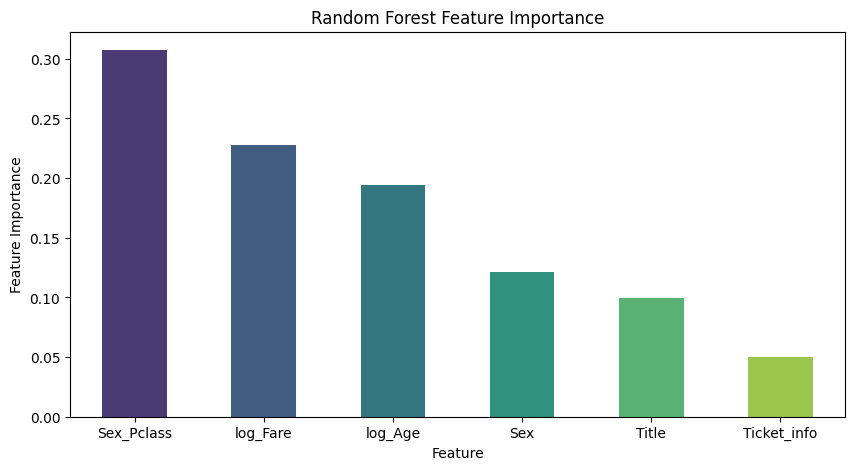

In [44]:
plt.figure(figsize=(10,5))
sns.barplot(x='feature', y='feature importance', data=rf_feature_importance_df, width=0.5, palette='viridis')
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.show()

In [45]:
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [1, 3, 5],
              'learning_rate': [0.01, 0.1, 1.0],
              'subsample': [0.3, 0.5, 0.7], #每棵樹的樣本比例
              'colsample_bytree': [0.5, 0.7, 1.0] #每棵樹的特徵比例
             }

cv = KFold(n_splits=3, shuffle=True, random_state=123)

xgb_cv = GridSearchCV(estimator = XGBClassifier(random_state=123),
                     param_grid = param_grid,
                     cv = cv,
                     scoring = 'f1',
                     n_jobs = -1)

xgb_cv.fit(X_train, y_train)

best_params = xgb_cv.best_params_
print('best parameters: ',best_params)

best parameters:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}


C:\Python310\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [46]:
xgb_model = XGBClassifier(**best_params) #解包字典
xgb_model.fit(X_train, y_train)

xgb_model.score(X_train, y_train), xgb_model.score(X_test, y_test)

(0.8932584269662921, 0.888268156424581)

In [47]:
y_pred = xgb_model.predict(X_test)

print('classification report: \n',classification_report(y_test, y_pred))
print('confusion matrix: \n', confusion_matrix(y_test, y_pred))

classification report: 
               precision    recall  f1-score   support

         0.0       0.90      0.93      0.91       114
         1.0       0.87      0.82      0.84        65

    accuracy                           0.89       179
   macro avg       0.88      0.87      0.88       179
weighted avg       0.89      0.89      0.89       179

confusion matrix: 
 [[106   8]
 [ 12  53]]


In [48]:
#特徵重要性排序
xgb_feature_importance = xgb_model.feature_importances_
xgb_feature_importance_df = pd.DataFrame({'feature': X_train.columns,
                                         'feature importance': xgb_feature_importance})
xgb_feature_importance_df = xgb_feature_importance_df.sort_values(by='feature importance',ascending=False)
xgb_feature_importance_df

,feature,feature importance
0,Sex,0.466220
1,Sex_Pclass,0.226285
2,Title,0.086743
3,log_Fare,0.077707
4,log_Age,0.075969
5,Ticket_info,0.067076


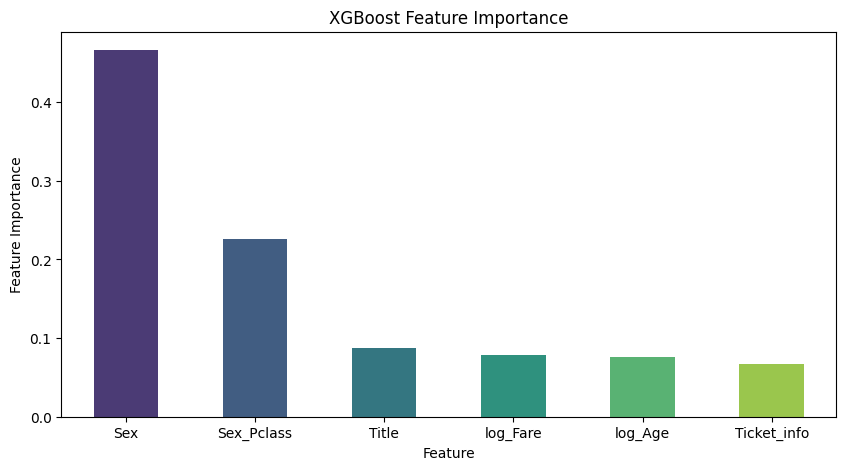

In [49]:
plt.figure(figsize=(10,5))
sns.barplot(x='feature', y='feature importance', data=xgb_feature_importance_df, width=0.5, palette='viridis', hue='feature')
plt.title('XGBoost Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.show()

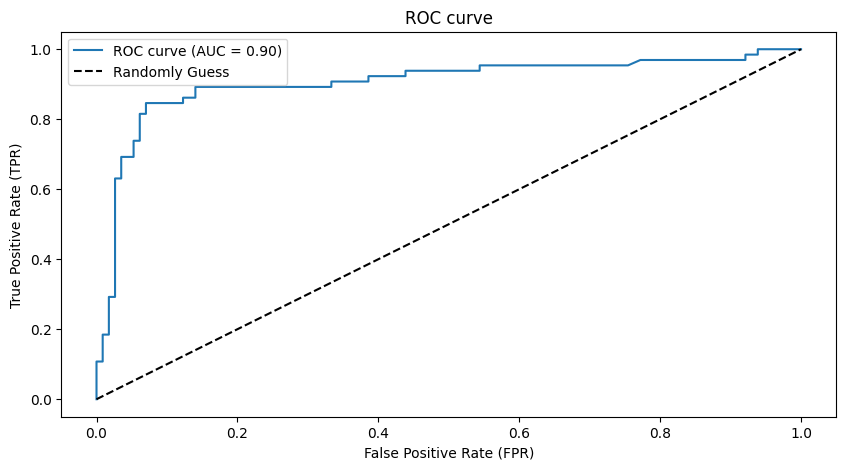

Best Threshold:  0.498
classification report with Best Threshold: 
               precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       114
         1.0       0.87      0.83      0.85        65

    accuracy                           0.89       179
   macro avg       0.89      0.88      0.88       179
weighted avg       0.89      0.89      0.89       179

confusion matrix with Best Threshold: 
 [[106   8]
 [ 11  54]]


In [50]:
#我們可以畫ROC curve，看看在何種分類門檻值(0~1)，哪裡的分類能力最好
y_score = xgb_model.predict_proba(X_test)[:,1]

#計算與繪製ROC curve
fpr, tpr, threshold = roc_curve(y_test, y_score)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_score):.2f})')
plt.plot([0,1], [0,1], 'k--', label='Randomly Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()

#用ROC曲線找出最好的點，是在這區線上，最接近(0,1)的地方，所以我們可以算(0,1)到(TPR,FPR)的最小距離，那個時候的threshold就是best_threshold...
distance = np.sqrt((1-tpr)**2 + (fpr)**2)
best_threshold = threshold[np.argmin(distance)]#計算所有(0,1)到(TPR,FPR)的距離，再用argmin()標示那個最小距離為1，其他都是0，選出這threshold作為best_threshold

print('Best Threshold: ',best_threshold.round(3))



#有了best_threshold，我們可以將y_pred分類以0.5為門檻，換成以best_threshold為門檻
y_score = xgb_model.predict_proba(X_test)[:,1]

y_pred_with_best_threshold = (y_score > best_threshold).astype(int) #超過best_threshold的y_scores是True，小於等於best_threshold的是False，再用astype()booling變int

#重劃分類表與混淆矩陣
print('classification report with Best Threshold: \n',classification_report(y_test, y_pred_with_best_threshold))
print('confusion matrix with Best Threshold: \n', confusion_matrix(y_test, y_pred_with_best_threshold))

In [51]:
# XGBClassifier?

In [53]:
best_val_pred = xgb_model.predict(data_val[['Sex', 'Sex_Pclass', 'Title', 'log_Fare', 'log_Age', 'Ticket_info']])

In [54]:
best_val_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [55]:
ans_titanic = pd.DataFrame({"PassengerId":data_val['PassengerId'], "Survived":best_val_pred})

In [58]:
ans_titanic.to_csv('ans_titanic.csv',index=False)
pd.read_csv('ans_titanic.csv')

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


<h1 style="font-size:20px; color:blue;">最後，使用DNN Model</h1>

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.layers import BatchNormalization, Input

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import r2_score

from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import os 

from keras.models import Sequential
from keras.layers import Dense, Input, BatchNormalization, Dropout, LeakyReLU

In [166]:
output_path = "dnn_output/category_baseline"

if not os.path.exists(output_path):
    os.makedirs(output_path)

# 早停
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


log_dir = "dnn_output/category_baseline"  
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [167]:
import keras.backend as K
import tensorflow as tf

def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)  # 使用 tf.round
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'))  # True Positives
    tn = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), 'float'))  # True Negatives
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'))  # False Positives
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'))  # False Negatives
    
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    
    return 2 * (precision * recall) / (precision + recall + K.epsilon())

# Configure Model
optimizer = Adam(learning_rate = 0.001)

dnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[f1_score]) # 'binary_accuracy'

In [168]:
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

from sklearn.model_selection import KFold
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard

kf = KFold(n_splits=5, shuffle=True, random_state=123)

# 初始化
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir="dnn_output/category_baseline", histogram_freq=1)

# KFold
for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    # 初始化
    dnn = Sequential([
        Dense(128, activation='relu', input_shape=(X_tr.shape[1],)),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(1, activation='sigmoid')
    ])
    
    # 編譯
    dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score])
    
    # 訓練
    history = dnn.fit(X_tr, y_tr, 
                      batch_size=16, 
                      epochs=100, 
                      verbose=1, 
                      validation_data=(X_val, y_val), 
                      callbacks=[reduce_lr, early_stop, tensorboard_callback])


Epoch 1/100


C:\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - f1_score: 0.4272 - loss: 0.7461 - val_f1_score: 0.0000e+00 - val_loss: 0.6101 - learning_rate: 0.0010
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - f1_score: 0.4015 - loss: 0.5701 - val_f1_score: 0.1004 - val_loss: 0.5785 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - f1_score: 0.3517 - loss: 0.5523 - val_f1_score: 0.1004 - val_loss: 0.5605 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score: 0.3549 - loss: 0.5155 - val_f1_score: 0.1388 - val_loss: 0.5274 - learning_rate: 0.0010
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - f1_score: 0.3675 - loss: 0.5258 - val_f1_score: 0.1881 - val_loss: 0.5052 - learning_rate: 0.0010
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - f1_score: 0.3497 - loss: 0.5120 - val_f1_score: 0.2377 - val_loss: 0.4783 - learning_rate: 0.0010
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - f1_score: 0.3503 - loss: 0.5063 - val_f1_s

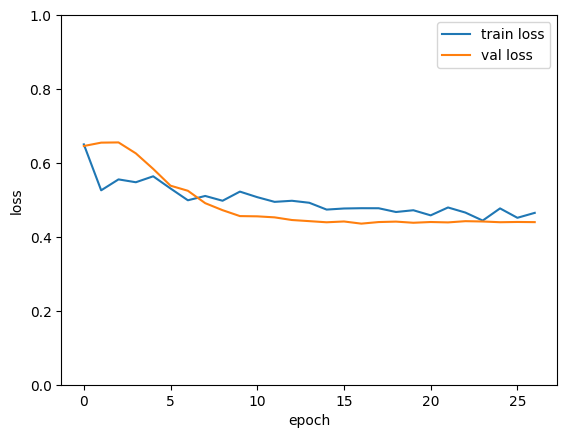

In [173]:
# Plot the learning history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.ylim([0,1])
plt.show()

In [170]:
y_pred_prob = dnn.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print('classification report: \n',classification_report(y_test, y_pred))
print('confusion matrix: \n', confusion_matrix(y_test, y_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 
classification report: 
               precision    recall  f1-score   support

         0.0       0.88      0.89      0.89       114
         1.0       0.81      0.78      0.80        65

    accuracy                           0.85       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179

confusion matrix: 
 [[102  12]
 [ 14  51]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


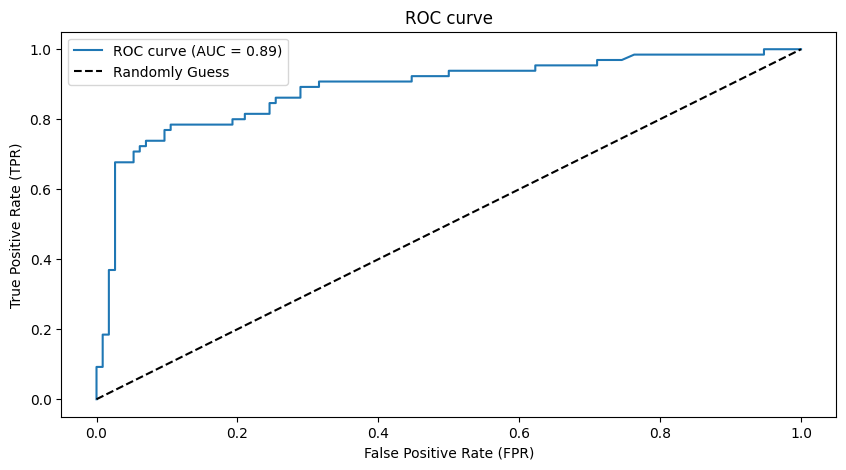

Best Threshold:  0.512
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
classification report with Best Threshold: 
               precision    recall  f1-score   support

         0.0       0.87      0.89      0.88       114
         1.0       0.81      0.77      0.79        65

    accuracy                           0.85       179
   macro avg       0.84      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179

confusion matrix with Best Threshold: 
 [[102  12]
 [ 15  50]]


In [171]:
#我們可以畫ROC curve，看看在何種分類門檻值(0~1)，哪裡的分類能力最好
y_score = dnn.predict(X_test)

#計算與繪製ROC curve
fpr, tpr, threshold = roc_curve(y_test, y_score)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_score):.2f})')
plt.plot([0,1], [0,1], 'k--', label='Randomly Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()

#用ROC曲線找出最好的點，是在這區線上，最接近(0,1)的地方，所以我們可以算(0,1)到(TPR,FPR)的最小距離，那個時候的threshold就是best_threshold...
distance = np.sqrt((1-tpr)**2 + (fpr)**2)
best_threshold = threshold[np.argmin(distance)]#計算所有(0,1)到(TPR,FPR)的距離，再用argmin()標示那個最小距離為1，其他都是0，選出這threshold作為best_threshold

print('Best Threshold: ',best_threshold.round(3))



#有了best_threshold，我們可以將y_pred分類以0.5為門檻，換成以best_threshold為門檻
y_score = dnn.predict(X_test)

y_pred_with_best_threshold = (y_score > best_threshold).astype(int) #超過best_threshold的y_scores是True，小於等於best_threshold的是False，再用astype()booling變int

#重劃分類表與混淆矩陣
print('classification report with Best Threshold: \n',classification_report(y_test, y_pred_with_best_threshold))
print('confusion matrix with Best Threshold: \n', confusion_matrix(y_test, y_pred_with_best_threshold))